Import the packages

In [1]:
import sys
sys.path.insert(0, '../../../')
import byxtal.lattice as gbl
import byxtal.integer_manipulations as iman
import byxtal.bp_basis as bpb
import numpy as np
import math as mt
import gbpy.util_funcs_create_byxtal as uf
import gbpy.generate_hkl_indices as ghi
from sympy.matrices import Matrix, eye, zeros

Define the primitive unit cell

In [2]:
# get the lattice parameter of Al
l1 = gbl.Lattice('cP_Id')
# Determine the primitive basis of fcc crystal structure
l_p_po = Matrix(l1.l_p_po)

l_po_p = l_p_po.inv()

In [3]:
## (h k l) indices of the fcc lattice (described in p)
h = 3
k = 4
l = 7

hkl_p = Matrix([h,k,l])

# hkl_p1
## l_bpb_p: Primitive Basis vectors of the boundary-plane (in p reference frame)
l_bpb_p = bpb.bp_basis(hkl_p)
l_bpb_p = Matrix(l_bpb_p.astype(int))

## l_bpb_p: Primitive Basis vectors of the boundary-plane (in po reference frame)
l_bpb_po = l_p_po*l_bpb_p

## Cut-off for area of the simulation box
lat_par = l1.lat_params['a']
r_cut = lat_par*2
A_cut = r_cut**2
## area_bpl: Area of the 2D-primitive-unit-cell
area_bpl = (l_bpb_po[:,0].cross(l_bpb_po[:,1])).norm()
# sig_num = np.ceil(A_cut/area_bpl)
sig_num = (A_cut/area_bpl).ceiling()

In [4]:
ind2 = np.array([], dtype='int64')
while (np.size(ind2) == 0):
    # Generate 2D hermite normal forms for sig_num (hnf_mats)
    hnf_mats = ghi.sig_hnf_mats(sig_num)
    # Compute the properties of the sub-lattices
    l_sig_p_mats, l_sig_po_mats = ghi.compute_hnf_props(hnf_mats, l_bpb_p, l_p_po)
    # Get the index for the sub-lattice that has the minimum cost
    ind2 = ghi.ind_min_cost(l_sig_po_mats, r_cut)
    sig_num = sig_num + 1

## l_bpbSig_p: Basis vectors of the sub-lattice of the boundary-plane (in p reference frame)
l_bpbSig_p = l_sig_p_mats[ind2]

l_bpbSig_p = Matrix(l_bpbSig_p.astype(int))
l_bpbSig_po = l_p_po*l_bpbSig_p

In [5]:
## GO: Orthogonal global reference frame (for LAMMPS)
## PO: Orhtogonal reference frame of the lattice
## compute_orientation: Will give the orientation of the crystal
##       such that the basis vectors in l_bpbSig_p are along the
##       x-axis and in the xy-plane
##
l_po_go = uf.compute_orientation(l_bpbSig_po)
# l_po_go = l_bpb_p
l2D_bpbSig_go = l_po_go*l_bpbSig_po
l2D_bpb_go = l_po_go*l_bpb_po
twoD_mat = l2D_bpb_go[:2,:]

second_atom = (np.array([1./2, 1./2, 1./2])).reshape(3,1)
shift = np.dot(l_po_go, second_atom)


In [6]:
twoDSig_mat = l2D_bpbSig_go[:2,:]
r_cut1 = uf.compute_rCut(l_bpbSig_po)
## Create 2D periodic box
twoD_pts = uf.replicate_pts(twoD_mat, r_cut1)
twoD_pts = uf.replicate_pts(twoD_mat, r_cut1)
twoD_pts = uf.remove_periodic_overlaps(twoD_pts, twoDSig_mat)

In [7]:
twoDSig_mat_arr = np.array(twoDSig_mat,dtype='float')
a_vec = twoDSig_mat_arr[:,0]; b_vec = twoDSig_mat_arr[:,1]


In [8]:
zCut = 25*lat_par
avec = l_bpb_p[:,0]
bvec = l_bpb_p[:,1]

l_p2_p1 = uf.find_int_solns(avec, bvec);

In [9]:
l_p2_po1 = (l_p_po*l_p2_p1)
l_p2_go = (l_po_go*l_p2_po1)
tz_vec = np.array(l_p2_go[:,2], dtype='double')
tz_vec = np.reshape(tz_vec, (3,))
# threeD_pts, sim_cell = uf.create_threeD_slab(zCut, tz_vec, l_bpbSig_po, twoD_pts)
# print(tz_vec)

################################################################################
## Translate 2D points in the Z-direction with zCut
num_rep = np.abs(int(np.ceil(zCut/tz_vec[2])))
num_2d = np.shape(twoD_pts)[0]
num_3d_pts = int((2*num_rep+1)*num_2d)
threeD_pts = np.zeros((num_3d_pts,3));

twoD_pts1 = np.hstack((twoD_pts, np.zeros((num_2d,1))));



In [10]:
for ct1 in np.arange(-num_rep, num_rep+1):
    ct2 = ct1 + num_rep;
    ind_st = (ct2)*num_2d;
    ind_stop = ind_st + num_2d;
    trans_vec = tz_vec*ct1;
    threeD_pts[ind_st:ind_stop, :] = twoD_pts1 + np.tile(trans_vec, (num_2d,1));
l_bpbSig_po_arr = np.array(l2D_bpbSig_go, dtype='double')

In [11]:
sim_cell = np.zeros((3,4))
sim_avec = l_bpbSig_po_arr[:,0]
sim_bvec = l_bpbSig_po_arr[:,1]

### Change this with inter-planar spacing
sim_cvec = np.array([0,0,2*zCut]); # sim_cvec = np.array([0,0,zCut]);
sim_orig = np.array([0,0,-zCut]); # sim_orig = np.array([0,0,0]);

sim_cell[:,0] = sim_avec
sim_cell[:,1] = sim_bvec
sim_cell[:,2] = sim_cvec
sim_cell[:,3] = sim_orig

box_vecs = sim_cell[:,0:3]
shift = shift.reshape(1,3)
threeD_pts_1 = threeD_pts + shift
threeD_pts_f = np.append(threeD_pts, threeD_pts_1,axis=0)
threeD_pts_final = uf.wrap_cc(sim_cell, threeD_pts_f)

In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def plot_2d_pts_box(twoD_pts, twoD_mat, orig):
    ################################################################################
    l1 = np.copy(twoD_mat);
    avec = l1[:,0]; bvec=l1[:,1];
    pts = np.zeros((4,2));
    pts[0,:] = orig;
    pts[1,:] = orig+avec; pts[2,:] = orig+avec+bvec; pts[3,:] = orig+bvec;
    tinds = [0,1,2,3,0];
    x1=pts[tinds,0];y1=pts[tinds,1];
    plt.plot(x1,y1);

    pts = np.copy(twoD_pts);
    x1=pts[:,0];y1=pts[:,1];
    plt.scatter(x1,y1);
    ################################################################################

def plot_3d_pts_box(fig, pts, tmat, sim_orig):
    ################################################################################
    ax = fig.add_subplot(111, projection='3d')

    box_pts = np.zeros((8,3));
    box_pts[1,:] = tmat[:,0]; box_pts[2,:] = tmat[:,0]+tmat[:,1];
    box_pts[3,:] = tmat[:,1];
    box_pts[4,:] = box_pts[0,:]+tmat[:,2];
    box_pts[5,:] = box_pts[1,:]+tmat[:,2];
    box_pts[6,:] = box_pts[2,:]+tmat[:,2];
    box_pts[7,:] = box_pts[3,:]+tmat[:,2];
    box_pts = box_pts + sim_orig;

    tinds = [0,1,2,3,0,4,5,6,7,4,0,1,5,6,2,3,7];
    x1 = box_pts[tinds,0]; y1 = box_pts[tinds,1]; z1 = box_pts[tinds,2];
    ax.plot(x1,y1,z1);

    x1=pts[:,0];y1=pts[:,1];z1=pts[:,2];
    ax.scatter(x1,y1,z1);

    ################################################################################


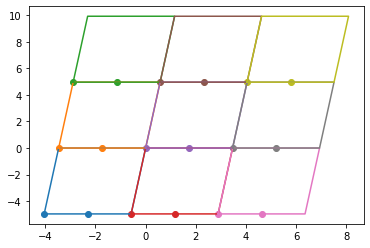

In [14]:
for tct1 in range(3):
    for tct2 in range(3):
        twoD_pts1 = 0*twoD_pts;
        orig = np.array([0,0])
        ct1 = tct1-1;
        ct2 = tct2-1;
        ct3 = 0; 
        twoD_pts1[:,ct3] = twoD_pts[:,ct3] + ct1*a_vec[ct3] + ct2*b_vec[ct3]
        ct3 = 1; 
        twoD_pts1[:,ct3] = twoD_pts[:,ct3] + ct1*a_vec[ct3] + ct2*b_vec[ct3]
        orig = ct1*a_vec + ct2*b_vec;
        plot_2d_pts_box(twoD_pts1, twoDSig_mat_arr, orig)
        # orig = ct1*a_vec + ct2*b_vec;
        # print(orig)

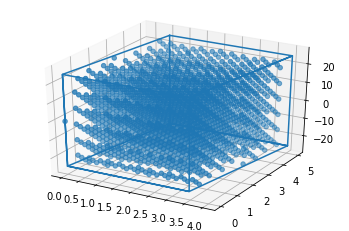

In [15]:
fig1 = plt.figure()
plot_3d_pts_box(fig1, threeD_pts_final, sim_cell[:,0:3], sim_orig); plt.show();

In [16]:
# writing the lammps dump file
def box_bound_func(sim_cell):
    origin_o = sim_cell[:, 3]
    xlo = origin_o[0]
    ylo = origin_o[1]
    zlo = origin_o[2]

    xhi = sim_cell[0, 0] + xlo
    xy = sim_cell[0, 1]
    yhi = sim_cell[1, 1] + ylo
    xz = sim_cell[0, 2]
    yz = sim_cell[1, 2]
    zhi = sim_cell[2, 2] + zlo

    if xy or xz or yz != 0:
        box_type = "prism"
    else:
        box_type = "block"

    xlo_bound = xlo + np.min(np.array([0, xy, xz, xy + xz]))
    xhi_bound = xhi + np.max(np.array([0, xy, xz, xy + xz]))
    ylo_bound = ylo + np.min(np.array([0, yz]))
    yhi_bound = yhi + np.max(np.array([0, yz]))
    zlo_bound = zlo
    zhi_bound = zhi

    if box_type == "block":
        box_bound = np.array([[xlo_bound, xhi_bound], [ylo_bound, yhi_bound], [zlo_bound, zhi_bound]])
    else:
        box_bound = np.array([[xlo_bound, xhi_bound, xy], [ylo_bound, yhi_bound,  xz], [zlo_bound, zhi_bound, yz]])
    return box_bound, box_type

def write_lammps_dump(filename0, box_bound, dump_lamp, box_type):
    """
    Function writes the lammps dump file.

    Parameters
    ------------
    filename0 :
        Name of the lammps dump file
    box_bound :
        The box bound needed to write lammps dump file which is 9 parameters: xlo, xhi, ylo, yhi,
        zlo, zhi, xy, xz, yz
    dump_lamp :
        A numpy nd.array having atom ID, atom type( 1 for upper grain and 2 for lower grain), x, y, z

    Returns
    ----------
    """
    p_x = box_bound[0, 1] - box_bound[0, 0]
    p_y = box_bound[1, 1] - box_bound[1, 0]
    p_z = box_bound[2, 1] - box_bound[2, 0]

    non_p_dir = np.argmax([p_x, p_y, p_z])

    num_atoms = np.shape(dump_lamp)[0]
    file = open(filename0, "w")
    file.write("ITEM: TIMESTEP\n")
    file.write("0\n")
    file.write("ITEM: NUMBER OF ATOMS\n")
    file.write(str(num_atoms) + "\n")
    # file.write("ITEM: BOX BOUNDS xy xz yz pp ff pp\n")
    if box_type == "prism":
        if non_p_dir == 0:
            file.write("ITEM: BOX BOUNDS xy xz yz ff pp pp\n")
        elif non_p_dir == 1:
            file.write("ITEM: BOX BOUNDS xy xz yz pp ff pp\n")
        else:
            file.write("ITEM: BOX BOUNDS xy xz yz pp pp ff\n")

    else:
        if non_p_dir == 0:
            file.write("ITEM: BOX BOUNDS ff pp pp\n")
        elif non_p_dir == 1:
            file.write("ITEM: BOX BOUNDS pp ff pp\n")
        else:
            file.write("ITEM: BOX BOUNDS pp pp ff\n")

    file.write(' '.join(map(str, box_bound[0])) + "\n")
    file.write(' '.join(map(str, box_bound[1])) + "\n")
    file.write(' '.join(map(str, box_bound[2])) + "\n")
    file.write("ITEM: ATOMS id x y z\n")
    file.close()
    mat = np.matrix(dump_lamp)
    with open(filename0, 'a') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%d %.10f %.10f %.10f')

In [17]:
num_atoms = len(threeD_pts_final)
ID = np.arange(num_atoms).reshape(num_atoms, 1) + 1
dump_lamp = np.concatenate((ID, threeD_pts_final), axis=1)
box_bound, box_type = box_bound_func(sim_cell)
write_lammps_dump('./bcc.dump', box_bound, dump_lamp, box_type)